In [1]:
import pandas as pd
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [21]:
from sklearn.ensemble import IsolationForest
from sklearn.linear_model import LinearRegression
plt.style.use('bmh')

In [56]:
header = ["appName","totalSourceBytes","totalDestinationBytes","totalDestinationPackets",
          "totalSourcePackets","sourcePayloadAsBase64","destinationPayloadAsBase64","destinationPayloadAsUTF",
          "direction","sourceTCPFlagsDescription","destinationTCPFlagsDescription","source",
          "protocolName","sourcePort","destination","destinationPort","startDateTime","stopDateTime","Tag"]
df = pd.read_csv('../UNB/flows/TestbedSunJun13Flows.csv')

In [57]:
df.head()

appName  totalSourceBytes  totalDestinationBytes  \
0  Unknown_UDP           2633658                      0   
1  Unknown_UDP           2633658                      0   
2      HTTPWeb                64                    128   
3      HTTPWeb                64                    128   
4      HTTPWeb               128                     64   

   totalDestinationPackets  totalSourcePackets sourcePayloadAsBase64  \
0                        0               28971                   NaN   
1                        0               28971                   NaN   
2                        2                   1                   NaN   
3                        2                   1                   NaN   
4                        1                   2                   NaN   

  sourcePayloadAsUTF destinationPayloadAsBase64 destinationPayloadAsUTF  \
0                NaN                        NaN                     NaN   
1                NaN                        NaN                     NaN   
2                NaN                        NaN                     NaN   
3                NaN                        NaN                     NaN   
4                NaN                        NaN                     NaN   

  direction sourceTCPFlagsDescription destinationTCPFlagsDescription  \
0       L2R                       NaN                            NaN   
1       L2R                       NaN                            NaN   
2       L2L                       F,A                              R   
3       L2L                       F,A                              R   
4       L2R                       F,A                            F,A   

          source protocolName  sourcePort     destination  destinationPort  \
0  192.168.5.122       udp_ip        5353     224.0.0.251             5353   
1  192.168.5.122       udp_ip        5353     224.0.0.251             5353   
2  192.168.2.113       tcp_ip        4191   192.168.5.122               80   
3  192.168.2.113       tcp_ip        4191   192.168.5.122               80   
4  192.168.2.113       tcp_ip        4192  207.241.148.80               80   

         startDateTime         stopDateTime     Tag  
0  2010-06-12T23:57:24  2010-06-13T09:24:52  Normal  
1  2010-06-12T23:57:24  2010-06-13T09:24:52  Normal  
2  2010-06-12T23:57:38  2010-06-12T23:59:20  Normal  
3  2010-06-12T23:57:38  2010-06-12T23:59:20  Normal  
4  2010-06-12T23:57:40  2010-06-12T23:59:20  Normal

In [58]:
G = nx.from_pandas_dataframe(df, 'source', 'destination', create_using=nx.DiGraph())

In [59]:
N, K = G.order(), G.size()
avg_deg = float(K) / N

print("Nodes: ", N)
print("Edges: ", K)
print("Average degree: ", avg_deg)
print("SCC: ", nx.number_strongly_connected_components(G))
print("WCC: ", nx.number_weakly_connected_components(G))

Nodes:  2659
Edges:  4986
Average degree:  1.87514103046258
SCC:  2631
WCC:  1


In [112]:
# Egonet of radius=1
N, E, W, L = [], [], [], []
for node in G.nodes():
    g2 = nx.ego_graph(G, node, radius=1)
    N.append(len(g2.nodes()))
    E.append(len(g2.edges()))
    # W.append(sum([ d['weight'] for (u,v,d) in g2.edges(data=True)]))
    # A = nx.adjacency_matrix(g2, weight='weight')
    # L.append(max(np.linalg.eigvals(A.todense())))

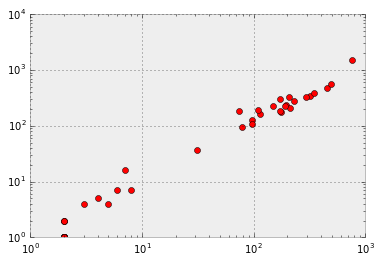

In [113]:
plt.loglog(N, E, 'ro')

In [114]:
y = np.array(E).reshape(-1, 1)
X = np.array(N).reshape(-1, 1)

def safe_ln(x, minval=0.0000000001):
    return np.log(x.clip(min=minval))

LR = LinearRegression(fit_intercept=True, normalize=True)
LR.fit(X, y)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=True)

In [115]:
alpha = np.real(LR.coef_)
C_all = y / X**alpha
C = np.real(C_all.mean())
print(np.real(C), np.real(alpha))
C = 0.000001

0.005029192848717232 [[ 1.46360075]]


In [116]:
outline = np.zeros((len(X)))
#outline = max(y, C*X**alpha) * np.log(abs(y - C*X**alpha) + 1) / ( min(y, C*X**alpha) + 0.0000000001)
for i in range(len(X)):
    outline[i] = max(y[i], C*X[i]**alpha) * np.log(abs(y[i] - C*X[i]**alpha) + 1) / ( min(y[i], C*X[i]**alpha) + 0.0000000001)

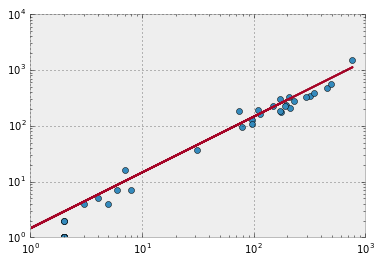

In [117]:
# plt.plot(safe_ln(X), safe_ln(y), 'o')
plt.loglog(N, E, 'o')
y = np.dot(np.array(N).reshape(-1,1), alpha)

plt.plot(N, y)
# plt.loglog(X, X**alpha)

In [141]:
X_train = np.vstack((N, E))
print(X_train.shape)
clf = IsolationForest(n_estimators=1000, contamination=0.001)
clf.fit(X_train.T)

(2, 2659)


IsolationForest(bootstrap=False, contamination=0.001, max_features=1.0,
        max_samples='auto', n_estimators=1000, n_jobs=1, random_state=None,
        verbose=0)

In [142]:
max_if_score = max(clf.decision_function(X_train.T))
print(max(clf.decision_function(X_train.T)))
print(min(clf.decision_function(X_train.T)))

0.0801209023673
-0.341005161463


In [143]:
final_score = outline/max(outline) - clf.decision_function(X_train.T)/max_if_score
# final_score = outline/max(outline)

In [144]:
top_scores = np.argsort(final_score)[-20:]
outlier_ips = [G.nodes()[i] for i in top_scores]

In [145]:
attack_sources = df[df["Tag"] == "Attack"]["source"].unique()
attack_dests = df[df["Tag"] == "Attack"]["destination"].unique()

In [146]:
[ip for ip in outlier_ips if (ip in attack_sources) or (ip in attack_dests)]

['192.168.1.104',
 '192.168.4.121',
 '192.168.2.111',
 '192.168.5.122',
 '192.168.3.117',
 '192.168.3.115',
 '192.168.4.118',
 '192.168.1.103',
 '192.168.4.119',
 '192.168.2.110',
 '192.168.1.101',
 '192.168.2.112',
 '192.168.2.106',
 '192.168.2.113',
 '192.168.1.105']